In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
import random

from torchmetrics.functional import r2_score

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

directory_path = r'data/train_images'
directory_csv = r'data/train.csv'


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 5 epoch is sufficient to get full mark.
  print('GPU is not detected. Make sure you have chosen the right runtime type')


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Everything looks good; continue


In [3]:
# Load the data
csv_file = pd.read_csv(directory_csv)

# Shuffle the data
df_shuffled = csv_file.sample(frac=1, random_state=42).reset_index(drop=True)

# get the split location
split = int(len(df_shuffled) * 0.8)

# Split into training and validation sets with 4:1 Ratio
train_np = df_shuffled.iloc[:split].values
val_np = df_shuffled.iloc[split:].values

# Create our standard scalar for the tabular data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [4]:
# Based on the normaliztion that occurs in the report posted on the kaggle competition (uses logged values)
# Returns the updated values and the min and maxes so it can be used on the validation and training set accordingly 
def normalize(x):
    min_v = x.min(axis=0).values
    max_v = x.max(axis=0).values
    return (x - min_v) / (max_v - min_v), min_v, max_v

# A Customer dataset class
class getDataSet(Dataset):
    def __init__(self, images_path, csv_data, transform=None):
        self.images_path = images_path
        self.csv_data = csv_data
        self.transform = transform
        self.data, self.images, self.targets = self._load_data()
        
    def __len__(self):
        return len(self.data)

    def _load_data(self):
       
        images = []
        targets = self.csv_data[:, -6:]
        # Transform the targets
        targets = np.log10(targets)
        # Convert to a tensor
        targets = torch.tensor(targets, dtype=torch.float32)

        # Take the tabular data
        data = self.csv_data[:, 1:-6]
        # Scale it using the scalar 
        data = scaler.fit_transform(data)
        # Get the ids to use for finding pictures in order
        ids = self.csv_data[:,0]

        for i in tqdm(ids):
            # Find the picture
            img_name = os.path.join(self.images_path, f"{int(i)}.jpeg")
            # Transform it and convert to rgb (3 channels)
            img = self.transform(Image.open(img_name).convert('RGB'))
            # Append to images
            images.append(img)
        
        # Return 3 things the tabular data, images, and target values
        return torch.tensor(data, dtype=torch.float32), images, targets
    
    # Gets the item
    def __getitem__(self, idx):
        return self.data[idx], self.images[idx], self.targets[idx]

# Transformations for my training set
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
    
])

# Transformations for my validation and test set
transform_v_t = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
    
])

# Load dataset
train = getDataSet(directory_path, train_np, transform=transform_train)
val_dataset = getDataSet(directory_path, val_np, transform=transform_v_t)

# Normalize the values
train.targets, min_tds, max_tds = normalize(train.targets)
val_dataset.targets = (val_dataset.targets - min_tds) / (max_tds - min_tds)

100%|██████████| 8673/8673 [00:27<00:00, 313.17it/s]


In [5]:

# Create Dataloaders
train_dataset = DataLoader(train, batch_size=256, shuffle=True, num_workers=8)
validation = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8)

In [6]:
class Dino(nn.Module):
    def __init__(self):
        super(Dino, self).__init__()
        # Load the dino model in
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        
        # Freeze all layers of the DINO model
        for param in self.dino.parameters():
            param.requires_grad = False
        
        # Allowing the model to learn
        self.dino_fc = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64)
        )

    def forward(self, x):
        x = self.dino(x)  
        x = self.dino_fc(x) 
        return x

# Define the tabular model
class TabularModel(nn.Module):
    def __init__(self):
        super(TabularModel, self).__init__()
        # A simple yet effective model for the tabular data
        self.model = nn.Sequential(
            nn.Linear(163, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
        )
    def forward(self, x):
        return self.model(x)

# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.image_model = Dino()
        self.tabular_model = TabularModel()
        # Model with combined inputs where each model returns 64 estimates
        self.combined_model = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 6)
        )

    def forward(self, tabular_data, image_data):
        image_features = self.image_model(image_data)
        tabular_features = self.tabular_model(tabular_data)
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        output = self.combined_model(combined_features)
        return output
    
model = CombinedModel()

torch.set_float32_matmul_precision('high')

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [ ]:
# Use the gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
epochs=40

model = model.to(device)
# Since this is a regression problem MSELoss is used
criterion = nn.MSELoss()

# Using the AdamW optimizer with 1e-3 learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Save the values
train_loss = []
val_loss = []
r2_vals = []

best_r2 = float('-inf')
best_epoch = 0
best_model_state = None

for epoch in range(epochs):
    print(f"epoch starting # {epoch}")
    # Running loss for this epoch
    running_loss = 0
    running_loss_v = 0
    # Set the model to training mode
    model.train()
    for tabular_data, image_data, target in tqdm(train_dataset):
        # Zeros the gradient
        optimizer.zero_grad()

        # Send the data to the gpu
        tabular_data = tabular_data.to(device)
        image_data = image_data.to(device)
        target = target.to(device)
        
        # Get the predictions and update
        out = model(tabular_data, image_data)
        loss = criterion(out, target)
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    v_p = []
    v_t = []
    # Set model to eval mode
    model.eval()
    for tabular_data, image_data, target in tqdm(validation):
        with torch.no_grad():
            tabular_data = tabular_data.to(device)
            image_data = image_data.to(device)
            target = target.to(device)
            out = model(tabular_data, image_data)
            loss = criterion(out, target)
            
            running_loss_v += loss.item()
            
            v_p.append(out)
            v_t.append(target)



    val_predictions = torch.cat(v_p, dim=0)
    val_targets = torch.cat(v_t, dim=0)
    # Calculate R2 Score
    r2 = r2_score(val_predictions, val_targets)

    
    # If improvement save the model
    if r2 > best_r2:
        best_r2 = r2
        best_epoch = epoch
        best_model_state = model.state_dict()
    
    # Save the values
    r2_vals.append(r2)
    val_loss.append(running_loss_v)
    train_loss.append(running_loss)

    print(f"Welcome to epoch #{epoch} with an R2 score of {r2}")

        
# Load the best model with the highest R2 score
model.load_state_dict(best_model_state)

cuda
epoch starting # 0


100%|██████████| 34/34 [00:19<00:00,  1.71it/s]


Welcome to epoch #0 with an R2 score of -0.14197225868701935
epoch starting # 1


100%|██████████| 34/34 [00:20<00:00,  1.70it/s]


Welcome to epoch #1 with an R2 score of 0.08477343618869781
epoch starting # 2


100%|██████████| 34/34 [00:18<00:00,  2.26it/s]

tensor(0.3684, device='cuda:0')
33
136
15.861920554190874


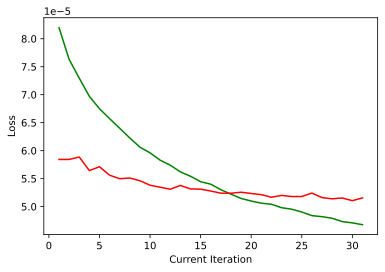

In [9]:
print(best_r2)
print(best_epoch)
x_axis = np.arange(1,31+1)
x_axis_t = np.arange(1,31+1)
print(len(train_dataset))
a = np.array(train_loss) / len(train)
b = np.array(val_loss) / len(val_dataset)
print(np.max(train_loss))
plt.plot(x_axis_t, a[4:], color='green', linestyle='-', label='Line 1')
plt.plot(x_axis, b[4:], color='red', linestyle='-', label='Line 1')
plt.xlabel("Current Iteration")
plt.ylabel("Loss")
plt.show()



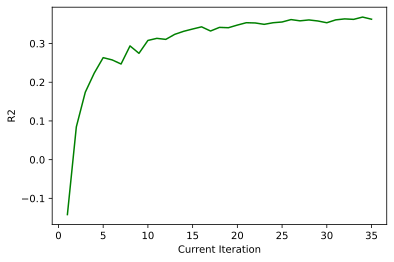

In [11]:
x_axis = np.arange(1,35+1)
vals = []
for x in r2_vals:
    vals.append(x.cpu())
plt.plot(x_axis, vals, color='green', linestyle='-', label='Line 1')

plt.xlabel("Current Iteration")
plt.ylabel("R2")
plt.show()

In [12]:

def denormalize(x):
      return 10**(x*(max_tds-min_tds) + min_tds)

test = r'data/test_images'
csv_file_test = r'data/test.csv'

file = pd.read_csv(csv_file_test)

idxs = file.iloc[:, 0].values
file.iloc[:,1:163] = scaler.fit_transform(file.iloc[:,1:163])
model.eval()
predictions = []


for index, row in tqdm(file.iterrows(), total=file.shape[0]):
    idx = row[0]
    path_name = str(int(idx)) + r'.jpeg'
    img_path = os.path.join(test, path_name)

    # Open and preprocess the image
    i = Image.open(img_path).convert('RGB')
    i = transform_v_t(i)
    i = i.unsqueeze(0).to(device)

    # Prepare the tabular data
    data = torch.tensor(row[1:].values, dtype=torch.float32).unsqueeze(0).to(device)
    # Make predictions with the model
    with torch.no_grad():
        output = model(data, i)

        # Apply denormalization
        output = denormalize(output.cpu())

    # Store the prediction
    predictions.append(output.squeeze(0).cpu().numpy())

    

100%|██████████| 6391/6391 [01:05<00:00, 97.88it/s] 


In [16]:
print(predictions[10])

df = pd.DataFrame(predictions, columns=['X4','X11','X18','X50','X26','X3112'])
df.insert(0,'id', idxs)


df.to_csv('submission.csv', index=False)

[1.06396556e+00 1.49623550e+02 1.97045547e+04 3.49069971e+03
 1.49173975e+01 3.99735125e+05]


In [17]:
print(best_r2)

tensor(0.3684, device='cuda:0')
